In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\chekitsch\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
import io
import os
import tradingWithPython as twp
from tradingWithPython import sharpe # general trading toolbox functions
import tradingWithPython.lib.yahooFinance as yf
import pandas as pd # pandas time series library
from datetime import datetime
import quandl
quandl.ApiConfig.api_key = 'wxychbrgu7o7x3MRq4Hx'

# read CSV from Yahoo and Google
try:
    nky = yf.getHistoricData('^N225', sDate=(2006,1,1))
    ndx = yf.getHistoricData('^NDX', sDate=(2006,1,1))
    dji = yf.getHistoricData('^DJI', sDate=(2006,1,1))
except Exception as e:
    print (e)

nky.loc['2016-10-05','close'] = 16819.240234000001      # correct yahoo data by hard-coding
nky.loc['2016-10-05','adj_close'] = 16819.240234000001  # correct yahoo data by hard-coding

# IMPORTANT - initialize pd.panel with symbol and dataframe (as a dict)
indexPanel = pd.Panel({'NKY':nky})

indexPanel['NDX'] = ndx
indexPanel['DJI'] = dji

try:
    path2 = r'http://www.google.com/finance/historical?cid=16606590&startdate=Jan+1%2C+2006&output=csv'
    tpx = pd.read_csv(path2, index_col=0, header = 0, parse_dates=True)
    tpx = tpx.rename(columns = dict(zip(list(tpx),('open', 'high', 'low', 'close', 'volume'))))  # rename columns
except Exception as e:
    print (e)
    
# conform topix to nikkei.index
tpx = tpx.reindex(nky.index)

indexPanel['TPX'] = tpx

# fetch close price only from panel
pairs = indexPanel.minor_xs('close')

NTpair = pd.DataFrame({'nky':pairs.NKY,'tpx':pairs.TPX})
NTpair = NTpair.dropna()

In [5]:
# read CSV from local drive
path1 = r'C:\Users\chekitsch\Documents\Trading\Historical data\JP\NTpair.csv'
NTpair = pd.read_csv(path1, index_col=0, header = 0, parse_dates=True)

In [6]:
existDate = NTpair.index[-1]

try:
    url = 'http://stocks.finance.yahoo.co.jp/stocks/history/?code=998407.O'
    tbl = pd.read_html(url, index_col = 0, header=0, parse_dates=True)
    df1 = tbl[1].set_index(pd.to_datetime(tbl[1].index, format='%Y年%m月%d日'))

    url = 'http://stocks.finance.yahoo.co.jp/stocks/history/?code=998405.T'
    tbl = pd.read_html(url, index_col = 0, header=0, parse_dates=True)
    df2 = tbl[1].set_index(pd.to_datetime(tbl[1].index, format='%Y年%m月%d日'))
except Exception as e:
    print (e)

nky_new = df1[df1.index > existDate].iloc[:,3].sort_index()
tpx_new = df2[df2.index > existDate].iloc[:,3].sort_index()

if len(nky_new) and len(tpx_new):
    print ('Existing Date: {0}   updating to nky_new.index(-1)'.format(existDate.date()))
    df_new = pd.DataFrame({'nky':nky_new, 'tpx': tpx_new})
    NTpair = NTpair.append(df_new)
    NTpair.to_csv(path1)
    print ('Update successful')
else:
    print ('Up to date as of ', existDate.date())

Existing Date: 2017-03-14   updating to nky_new.index(-1)
Update successful


In [7]:
NTpair.pct_change().corr()

,nky,tpx
nky,1.000000,0.958928
tpx,0.958928,1.000000


## Build spread

In [8]:
NTpair['spread_pct'] = NTpair.nky.pct_change() - NTpair.tpx.pct_change()
delta = 10   # x-day return
NTpair['spread_pct_N'] = NTpair.nky.pct_change(delta) - NTpair.tpx.pct_change(delta)
NTpair['spread'] = NTpair.nky*8 - NTpair.tpx*100  # spread scaled according to futures multiplier
NTpair['spread_ratio'] = NTpair.nky / NTpair.tpx

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000009DC1668>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000A4D43C8>], dtype=object)

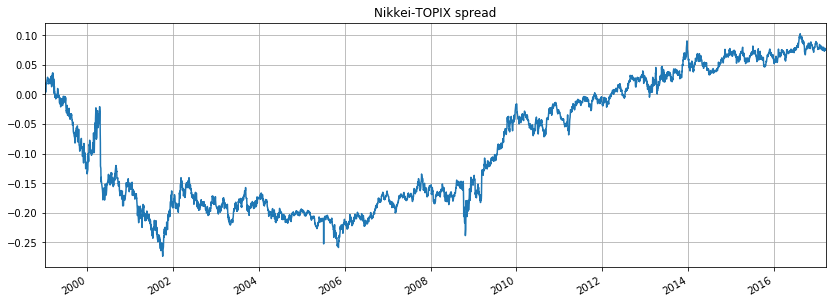

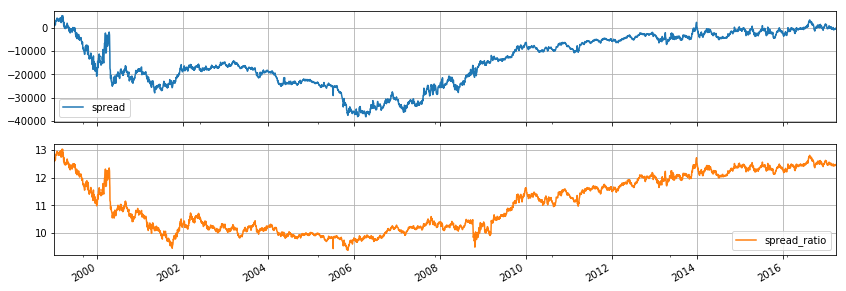

In [9]:
figsize(14,5)
title('Nikkei-TOPIX spread')
NTpair['spread_pct'].cumsum().tail(6000).plot(grid=True)
NTpair[['spread','spread_ratio']].tail(6000).plot(subplots=True,grid=True)

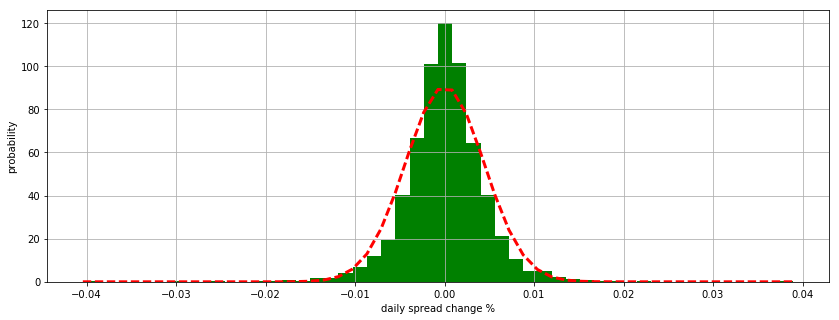

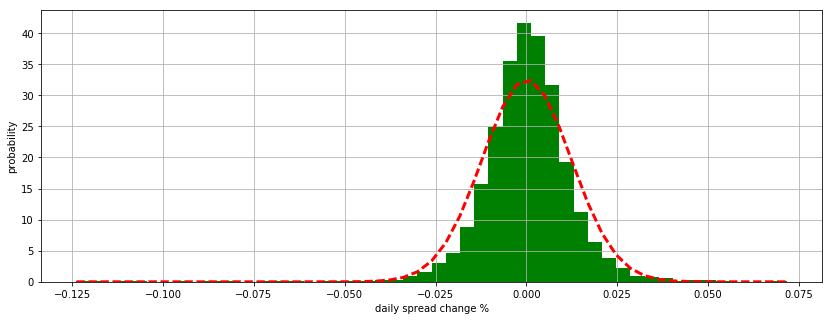

In [10]:
R = NTpair['spread_pct'].dropna()
n, bins ,patches = hist(R,50,normed=1,facecolor='green') # plot returns histogram with 50 bins
y = normpdf(bins,R.mean(),R.std())
plot(bins,y,'r--',linewidth=3)
xlabel('daily spread change %')
ylabel('probability')
grid(True)

figure()
R_nday = NTpair['spread_pct_N'].dropna()
n, bins ,patches = hist(R_nday,50,normed=1,facecolor='green') # plot returns histogram with 50 bins
y = normpdf(bins,R_nday.mean(),R_nday.std())
plot(bins,y,'r--',linewidth=3)
xlabel('daily spread change %')
ylabel('probability')
grid(True)

            spread  spread_ratio   z_score    cumRet        ma  momentum
2017-03-17 -412.28     12.467088 -1.378522  7.630583  7.938608 -0.308025
2017-03-21 -694.96     12.444436 -1.104323  7.449168  7.928750 -0.479581
2017-03-22 -688.96     12.443720  0.216258  7.443536  7.917635 -0.474099
2017-03-23 -358.52     12.470717  1.823837  7.660520  7.908198 -0.247678
2017-03-24 -291.76     12.476378  1.533202  7.706318  7.901595 -0.195277


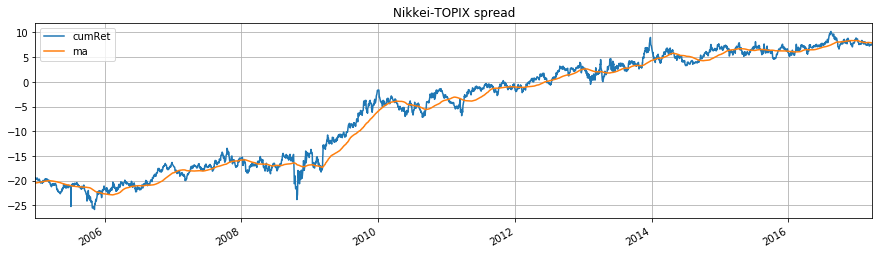

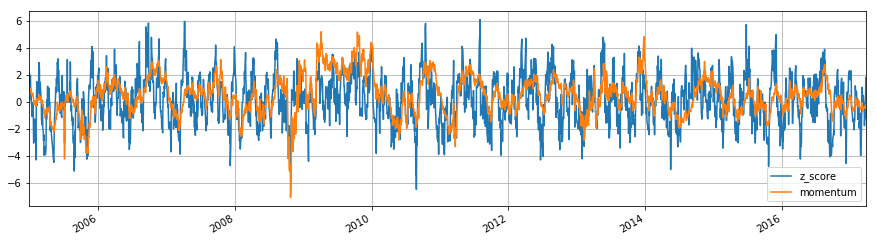

In [172]:
indicators = pd.DataFrame(index = R.index) #prepare indicators DataFrame

indicators['spread'] = NTpair['spread']
indicators['spread_ratio'] = NTpair['spread_ratio']
indicators['z_score'] = R_nday/R_nday.rolling(window=10).std() # current day return z-score
indicators['cumRet'] = 100 * R.cumsum() # total sum of returns, which is a sythetic price
indicators['ma'] = indicators['cumRet'].rolling(window=100).mean() #moving average of synthetic price
indicators['momentum'] = indicators['cumRet']-indicators['ma'] # difference between synth. 
                                                                #price and ma, gives indication of momentum strength
print (indicators.tail(5))

figsize(15,4)
indicators[['cumRet','ma']].tail(3000).plot(grid=True)
title('Nikkei-TOPIX spread')
figure()
indicators[['z_score','momentum']].tail(3000).plot(grid=True)

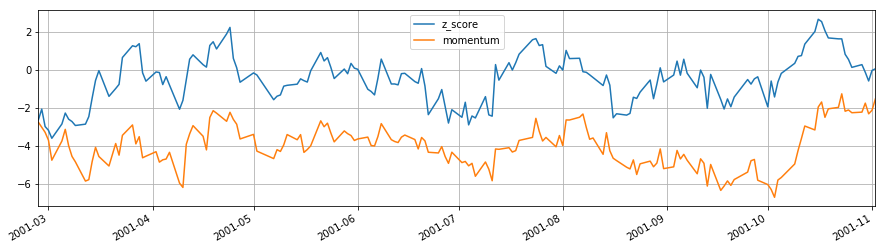

In [37]:
indicators[['z_score','momentum']][527:700].plot(grid=True)

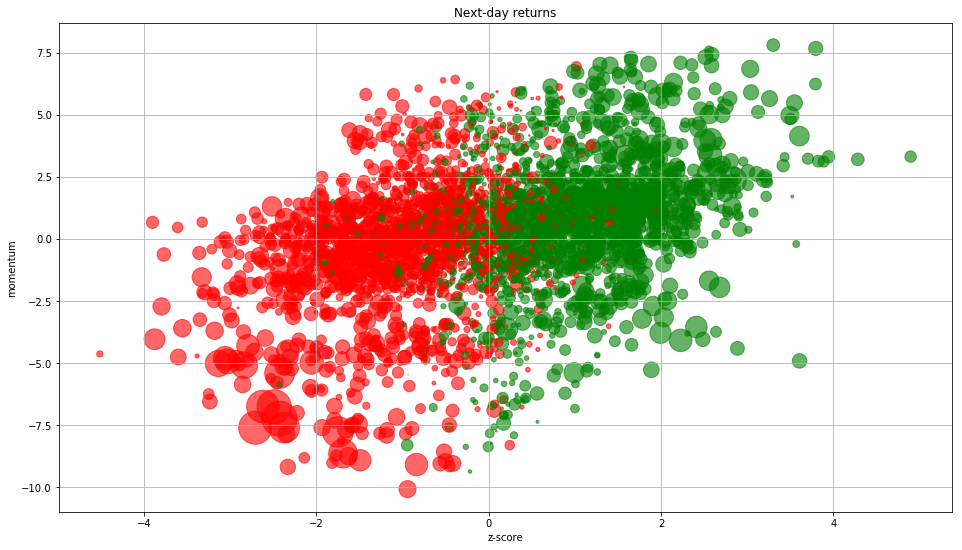

In [12]:
#---create a scatter plot of next day retruns
figsize(16,9)
data = indicators.copy() # create a copy of indicators dataframe in data, which will be used for scatterplot
data['R'] = R_nday # current return
data['R_next'] = R_nday.shift(-1) # next day return, used for circle size, color will be used to show sign

data = data.dropna()

color = pd.Series(index=data.index, data='white')
color[data['R_next']>0] = 'green' # positives are green
color[data['R_next']<0] = 'red' # negatives are red

scatter(data['z_score'],data['momentum'], s=np.abs(10000*data['R_next']),c=color.tolist(),alpha=0.6) # note the 'abs' function, as circle diameter must be positive
grid(True)
xlabel('z-score')
ylabel('momentum')
title('Next-day returns')

## Potential strategies ##
* z-score > 2 and momentum > 0
* momentum > 1.5
* daily return z-score and n-day return z-score (to catch big but gradual deviations from mean)

In [96]:
def backtest(ret_nday, ret_1d, window=15, ma_thresh = 0.6, ma_window=50, z_enter=2.5, z_enter2=0, z_exit=1.75):
    """
    Parameters
    ret_nday: n-day rolling returns (designed to catch big but gradual deviation from mean)
    ret_1d: 1-day return used to calculate synthetic price
    window: used to calculate z-score (entry signal) on n-day rolling returns
    ma_thresh: additional entry signal to complement z-score; difference between synth. price and its moving avg
    z_enter: threshold to initiate position
    z_enter2: default = 0 (i.e. off), add to initial position
    z_exit: target level (exit signal) used to close position
    
    """
    
    price = 100 * ret_1d.cumsum()  # synthetic price
        
    #----indicators
    z_score = ret_nday / ret_nday.rolling(window=window).std()  # current day z-score
    aboveAverage = (price - price.rolling(window=ma_window).mean()) > ma_thresh # is the price above average by 0.5? T/F, window size fixed
    belowAverage = (price - price.rolling(window=ma_window).mean()) < -ma_thresh # is the price below average by 0.5? T/F, window size fixed

    """ backtest with entering on a given z_score """
    pos = pd.Series(index = ret_nday.index, data = 0)  # position vector

    pos[(aboveAverage & (z_score > z_enter))] = -1 # short position
    pos[(belowAverage & (z_score < -z_enter))] = 1 # long position
    if z_enter2:                                    # double down if z-score hits 2nd z-entry
        pos[(aboveAverage & (z_score > z_enter2))] = -2 # short position
        pos[(belowAverage & (z_score < -z_enter2))] = 2 # long position
    
    for i,p in enumerate(pos):
        if i > 0 and pos[i] <= pos[i-1] and pos[i-1] > 0 and z_score[i] < z_exit:  # if long, and z_score has not hit target, hold
            pos[i] = pos[i-1]
        elif i > 0 and pos[i] >= pos[i-1] and pos[i-1] < 0 and z_score[i] > -z_exit:  # if short position and z_score has not hit target, keep shorting
            pos[i] = pos[i-1]
            
    #print (pos.value_counts())
    pos = pos.shift(1) # todays position has effect on tomorrows return. Shift 1 day into future.
    pnl = ret_1d*pos # daily pnl 
    return pd.DataFrame({'pnl':pnl,'pos':pos, 'z_score':z_score})


In [274]:
NTdf = backtest(NTpair['spread_pct_N'], NTpair['spread_pct'], window=10, ma_thresh = 0.5, ma_window=100, z_enter=2.5, z_enter2=3.8, z_exit=1.6)


Sharpe since 2000:  0.664913461221
Sharpe trailing 750 days: 1.6447239315883646
750-day P&L: 0.21595802455139312


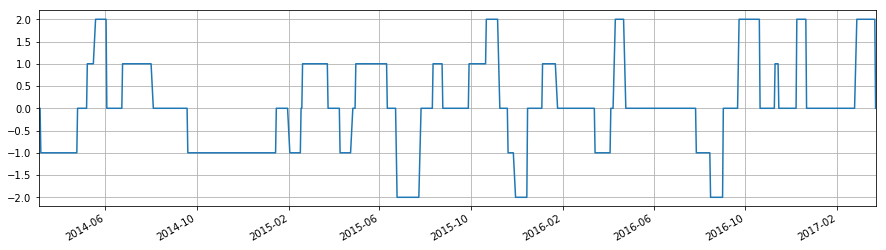

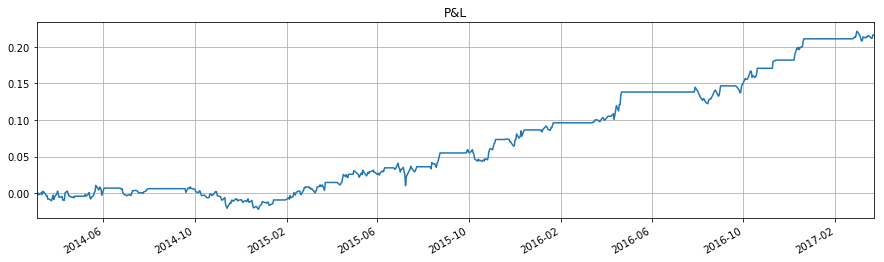

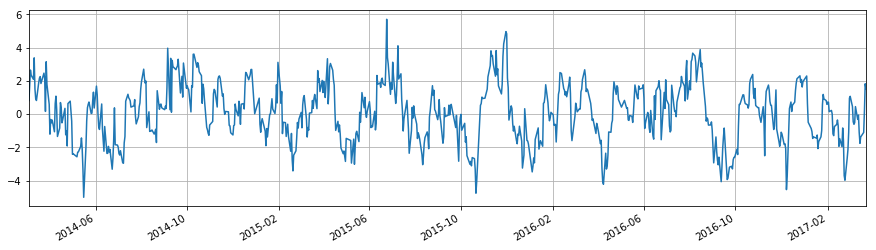

In [275]:
period = 750
figsize(15,4)
NTdf.pos.tail(period).plot(grid=True)
#title('Position')
figure()
NTdf.pnl.tail(period).cumsum().plot(grid=True)
title('P&L')
figure()
NTdf.z_score.tail(period).plot(grid=True)
print ('Sharpe since 2000: ', twp.sharpe(NTdf.pnl))
print ('Sharpe trailing {0} days: {1}'.format(period, twp.sharpe(NTdf.pnl.tail(period))) )
print ('{0}-day P&L: {1}'.format(period, NTdf.pnl.tail(period).cumsum()[-1]))

In [189]:
NTdf.tail()

,pnl,pos,z_score
2017-03-17,0.001700,2.0,-1.378522
2017-03-21,-0.003628,2.0,-1.104323
2017-03-22,-0.000113,2.0,0.216258
2017-03-23,0.004340,2.0,1.823837
2017-03-24,0.000000,0.0,1.533202


## Optimize z-entry and z-exit ##

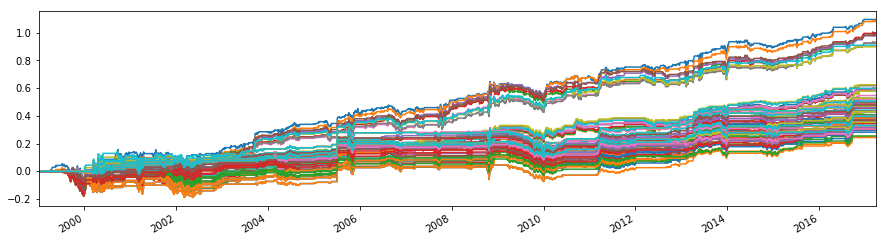

In [208]:
""" optimize and optionally plot pnl """
        
window = np.arange(10,50,5)  # backtest for z-entry 0.5 to 3, steps of 0.1
ma_window = np.arange(60,260,20)  # backtest for z-exit -1.0 to 0.5, steps of 0.1
sharpe = np.zeros((len(window), len(ma_window)))
        
for i,win1 in enumerate(window):
    for j,win2 in enumerate(ma_window):
        NTdf = backtest(R_nday, R, window=win1, ma_thresh = 0.5, ma_window=win2, z_enter=2.5, z_enter2=3.75, z_exit=1.7)
        sharpe[i,j] = twp.sharpe(NTdf.pnl)
        NTdf.pnl.cumsum().plot()

i:  10
j:  80


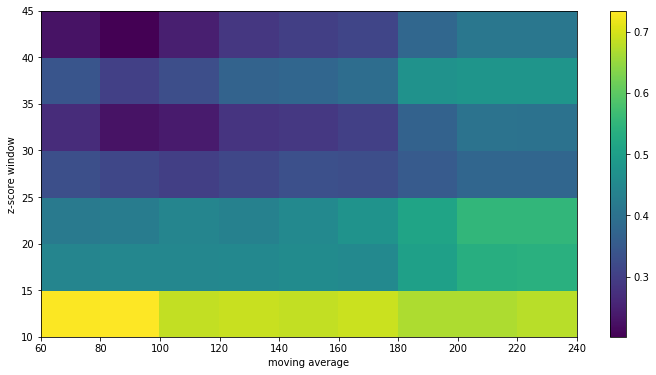

In [209]:
figsize(12,6)
pcolor(ma_window, window, sharpe)
ylabel('z-score window')
xlabel('moving average');
colorbar();

i,j = np.unravel_index(sharpe.argmax(), sharpe.shape)
print ("i: ", window[i])
print ("j: ", ma_window[j])

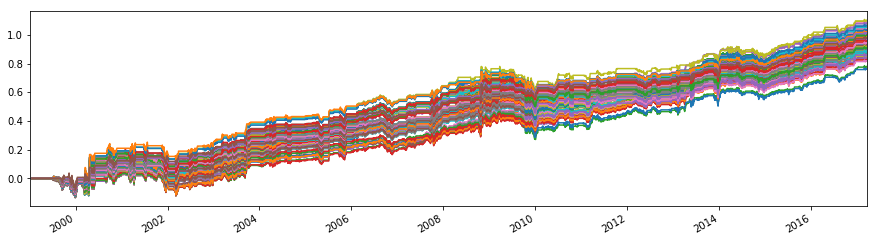

In [156]:
""" optimize and optionally plot pnl """
        
z_enter = np.arange(1.8,3.0,0.1)  # backtest for z-entry 0.5 to 3, steps of 0.1
z_enter2 = np.arange(3.2,4.0,0.1)  # backtest for z-exit -1.0 to 0.5, steps of 0.1
sharpe = np.zeros((len(z_enter), len(z_enter2)))
        
for i,z1 in enumerate(z_enter):
    for j,z2 in enumerate(z_enter2):
        NTdf = backtest(R_nday, R, window=10, ma_thresh = 0.5, ma_window=100, z_enter=z1, z_enter2=z2, z_exit=1.7)
        sharpe[i,j] = twp.sharpe(NTdf.pnl)
        NTdf.pnl.cumsum().plot()

i:  2.9
j:  3.8


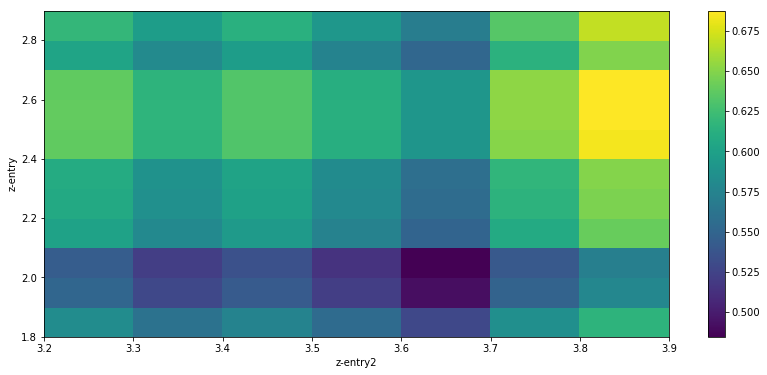

In [158]:
figsize(14,6)
pcolor(z_enter2, z_enter, sharpe)
xlabel('z-entry2');
ylabel('z-entry')
colorbar();

i,j = np.unravel_index(sharpe.argmax(), sharpe.shape)
print ("i: ", z_enter[i])
print ("j: ", z_enter2[j])

## Out of sample / walk forward

In [198]:
''' select period for model calibration'''

train = NTpair[-1800:-800]

In [205]:
window = np.arange(10,50,5)  # backtest for z-entry 0.5 to 3, steps of 0.1
ma_window = np.arange(60,260,20)  # backtest for z-exit -1.0 to 0.5, steps of 0.1
sharpe = np.zeros((len(window), len(ma_window)))
        
for i,win1 in enumerate(window):
    for j,win2 in enumerate(ma_window):
        NTdf = backtest(train['spread_pct_N'], train['spread_pct'], window=win1, ma_thresh = 0.5, ma_window=win2, z_enter=2.5, z_enter2=3.8, z_exit=1.7)
        sharpe[i,j] = twp.sharpe(NTdf.pnl)

i,j = np.unravel_index(sharpe.argmax(), sharpe.shape)
print (window[i])
print (ma_window[j])

35
60


In [206]:
df = pd.DataFrame(index = NTpair.index)
df['full'] = backtest(NTpair['spread_pct_N'], NTpair['spread_pct'], window=window[i], ma_thresh = 0.5, ma_window=ma_window[j], z_enter=2.5, z_enter2=3.75, z_exit=1.9).pnl
df['train'] = backtest(train['spread_pct_N'], train['spread_pct'], window=window[i], ma_thresh = 0.5, ma_window=ma_window[j], z_enter=2.5, z_enter2=3.75, z_exit=1.9).pnl

0.34609718825906732

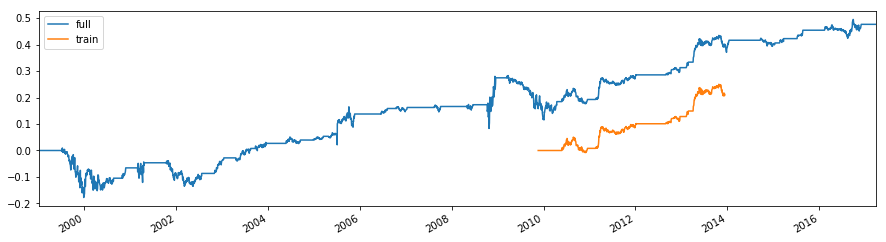

In [207]:
df.cumsum().plot()
twp.sharpe(df.full)